# Importing necessary libraries and settings

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
# çıktının tek bir satırda olmasını sağlar.
pd.set_option('display.expand_frame_repr', False)
from mlxtend.frequent_patterns import apriori, association_rules
import seaborn as sns
import matplotlib.pyplot as plt

# Loading and Understanding Data

In [2]:
df = pd.read_excel("/kaggle/input/uci-online-retail-ii-data-set/online_retail_II.xlsx",sheet_name="Year 2010-2011")
def check_df(dataframe):
    print("##################### First 10 Observations #####################")
    print(dataframe.head(10))
    print("##################### Column names #####################")
    print(df.info())
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Types #####################")
    print(dataframe.dtypes)
check_df(df)

##################### First 10 Observations #####################
  Invoice StockCode                          Description  Quantity         InvoiceDate  Price  Customer ID         Country
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6 2010-12-01 08:26:00   2.55      17850.0  United Kingdom
1  536365     71053                  WHITE METAL LANTERN         6 2010-12-01 08:26:00   3.39      17850.0  United Kingdom
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8 2010-12-01 08:26:00   2.75      17850.0  United Kingdom
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6 2010-12-01 08:26:00   3.39      17850.0  United Kingdom
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6 2010-12-01 08:26:00   3.39      17850.0  United Kingdom
5  536365     22752         SET 7 BABUSHKA NESTING BOXES         2 2010-12-01 08:26:00   7.65      17850.0  United Kingdom
6  536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6 2010-1

We are going to clean the data, we'll get rid of cancelled orders, negative numbers, and outliers

In [3]:
df = df[~df["StockCode"].str.contains("POST", na=False)]

In [4]:
df.shape

(540653, 8)

In [5]:
df.dropna(inplace=True)

In [6]:
df.shape

(405633, 8)

In [7]:
df = df[~df["Invoice"].str.contains("C", na=False)]


In [8]:
df.shape

(396825, 8)

In [9]:
df = df[(df['Price'] > 0)]
df.shape

(396785, 8)

In [10]:
df = df[(df['Quantity'] > 0)]
df.shape

(396785, 8)

In [11]:
df.describe()

,Quantity,Price,Customer ID
count,396785.000000,396785.000000,396785.000000
mean,13.016349,3.037677,15301.463886
std,179.579125,17.829741,1709.852311
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13975.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16801.000000
max,80995.000000,4161.060000,18287.000000


The table above show us there are outliers in Quantity and Price variables.


In [12]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [13]:
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

In [14]:
df.describe()

,Quantity,Price,Customer ID
count,396785.000000,396785.000000,396785.000000
mean,8.332392,2.584720,15301.463886
std,8.102520,2.090248,1709.852311
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13975.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16801.000000
max,27.000000,7.500000,18287.000000


Let's see distribution of Quantity and Price variables

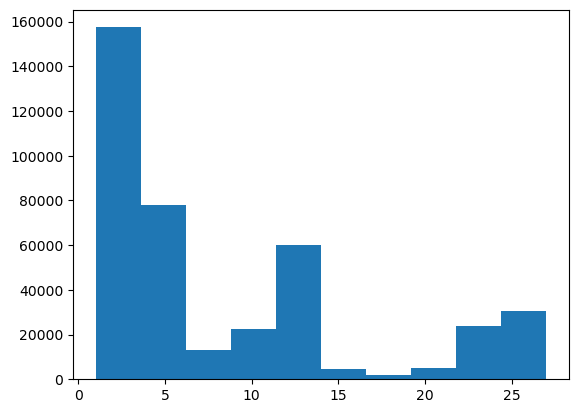

In [15]:
plt.hist(df["Quantity"])
plt.show(block=True)

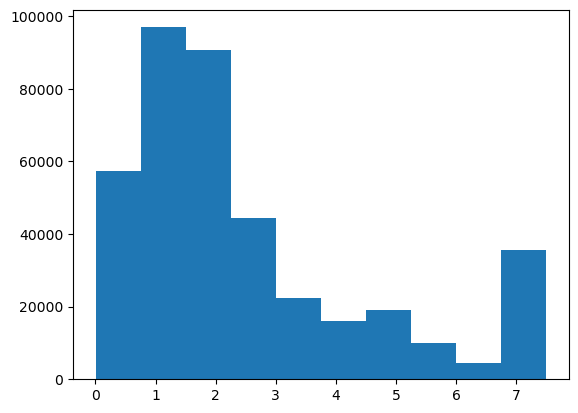

In [16]:
plt.hist(df["Price"])
plt.show(block=True)

In [17]:
def create_invoice_product_df(dataframe, id=False):
    if id:
        return dataframe.groupby(['Invoice', "StockCode"])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)
    else:
        return dataframe.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)

In [18]:
df_ger = df[df['Country'] == "Germany"]

In [19]:
ger_inv_pro_df = create_invoice_product_df(df_ger,id=True)
ger_inv_pro_df.head()

StockCode  10002  10125  10135  11001  15034  15036  15039  16008  16011  16014  16016  16045  16054  16218  16235  16236  16237  16238  16259  17003  20652  20658  20665  20668  20674  20675  20676  20677  20679  20681  20682  20684  20685  20696  20702  20704  20705  20707  20711  20712  20713  20716  20717  20718  20719  20723  20724  20725  20726  20727  20728  20749  20750  20751  20752  20754  20755  20761  20766  20767  20772  20774  20794  20796  20828  20846  20897  20902  20903  20914  20961  20963  20971  20972  20973  20974  20975  20977  20978  20979  20981  20982  20983  20984  20992  20997  20998  21002  21014  21015  21025  21034  21035  21039  21041  21042  21051  21054  21055  21056  21058  21059  21061  21062  21068  21078  21080  21084  21086  21088  21090  21094  21096  21108  21110  21114  21115  21116  21121  21122  21123  21124  21125  21126  21128  21135  21136  21137  21154  21155  21156  21158  21159  21164  21165  21169  21175  21194  21196  21197  21202  21204  21205  21206  21207  21208  21209  21210  21211  21212  21213  21215  21216  21217  21218  21219  21220  21221  21224  21226  21231  21232  21238  21239  21240  21242  21243  21244  21245  21246  21249  21250  21251  21257  21258  21259  21262  21264  21272  21277  21284  21289  21291  21292  21293  21311  21314  21318  21320  21328  21329  21340  21354  21355  21358  21360  21371  21374  21380  21381  21383  21389  21392  21394  21395  21397  21398  21399  21401  21402  21403  21408  21411  21415  21424  21426  21427  21428  21429  21430  21439  21441  21446  21447  21452  21456  21458  21462  21467  21471  21479  21481  21484  21485  21494  21495  21497  21498  21499  21500  21503  21504  21506  21507  21508  21509  21519  21523  21524  21527  21531  21533  21534  21535  21537  21539  21544  21555  21556  21558  21559  21561  21562  21563  21564  21576  21577  21578  21579  21580  21581  21588  21592  21615  21620  21621  21622  21624  21625  21628  21642  21650  21656  21658  21666  21668  21669  21670  21671  21672  21673  21675  21679  21680  21682  21683  21698  21700  21703  21704  21705  21706  21707  21708  21710  21715  21716  21718  21719  21723  21724  21731  21735  21739  21741  21746  21747  21749  21754  21755  21756  21770  21773  21774  21775  21786  21787  21788  21789  21791  21809  21811  21817  21826  21828  21829  21832  21843  21844  21871  21873  21874  21877  21878  21880  21881  21882  21883  21884  21889  21890  21891  21892  21894  21896  21899  21903  21905  21906  21907  21908  21914  21915  21916  21917  21918  21925  21926  21927  21928  21929  21930  21931  21932  21933  21934  21935  21936  21937  21944  21948  21949  21955  21967  21972  21973  21974  21975  21976  21977  21980  21981  21982  21983  21984  21985  21986  21987  21988  21989  21990  21991  21992  21993  22021  22024  22025  22026  22027  22028  22029  22030  22031  22032  22035  22037  22040  22041  22042  22044  22045  22046  22047  22048  22049  22050  22051  22055  22057  22059  22060  22061  22062  22063  22064  22066  22067  22070  22072  22073  22074  22075  22076  22077  22078  22079  22080  22081  22082  22083  22085  22086  22087  22088  22089  22090  22091  22093  22094  22097  22098  22099  22100  22110  22111  22112  22113  22114  22117  22119  22123  22124  22128  22129  22130  22131  22134  22135  22138  22139  22141  22142  22144  22147  22148  22149  22150  22151  22163  22164  22168  22169  22171  22173  22174  22175  22176  22178  22179  22180  22181  22186  22187  22189  22190  22191  22192  22193  22195  22196  22197  22199  22200  22201  22202  22203  22204  22207  22208  22209  22210  22211  22212  22215  22220  22221  22222  22223  22228  22230  22231  22232  22233  22236  22242  22243  22244  22245  22246  22247  22252  22254  22255  22258  22260  22262  22263  22264  22271  22272  22273  22274  22276  22277  22278  22279  22280  22281  22296  22300  22301  22302  22303  22304  22307  22311  22315  22316  22317  22318 

Invoice-Product table, that is going to be used for creating ariori algorithms and rules

In [20]:
def create_rules(dataframe):
    frequent_itemsets = apriori(dataframe, min_support=0.01, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.01)
    return rules

In [21]:
rules = create_rules(ger_inv_pro_df)
rules

/opt/conda/lib/python3.7/site-packages/mlxtend/frequent_patterns/fpcommon.py:115: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  DeprecationWarning,


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(16237),(22326),0.011136,0.249443,0.011136,1.000000,4.008929,0.008358,inf
1,(22326),(16237),0.249443,0.011136,0.011136,0.044643,4.008929,0.008358,1.035073
2,(20674),(20675),0.022272,0.033408,0.013363,0.600000,17.960000,0.012619,2.416481
3,(20675),(20674),0.033408,0.022272,0.013363,0.400000,17.960000,0.012619,1.629547
4,(20674),(20676),0.022272,0.037862,0.011136,0.500000,13.205882,0.010293,1.924276
...,...,...,...,...,...,...,...,...,...
18365,(22629),"(22467, 22326, 22423, 21915, 22077)",0.104677,0.011136,0.011136,0.106383,9.553191,0.009970,1.106586
18366,(22326),"(22467, 22629, 22423, 21915, 22077)",0.249443,0.011136,0.011136,0.044643,4.008929,0.008358,1.035073
18367,(22423),"(22467, 22629, 22326, 21915, 22077)",0.140312,0.011136,0.011136,0.079365,7.126984,0.009573,1.074111
18368,(21915),"(22467, 22629, 22326, 22423, 22077)",0.046771,0.011136,0.011136,0.238095,21.380952,0.010615,1.297884


In [22]:
def arl_recommender(rules_df, product_id, rec_count=1):
    sorted_rules = rules_df.sort_values("lift", ascending=False)
    recommendation_list = []
    for i, product in enumerate(sorted_rules["antecedents"]):
        for j in list(product):
            if j == product_id:
                recommendation_list.append(list(sorted_rules.iloc[i]["consequents"])[0])

    return recommendation_list[0:rec_count]

In [23]:
def check_id(dataframe, stock_code):
    product_name = dataframe[dataframe["StockCode"] == stock_code][["Description"]].values[0].tolist()
    print(product_name)

In [24]:
product_id = 22492
product_name = check_id(df, product_id)
product_name

['MINI PAINT SET VINTAGE ']


In [25]:
reccomend_list = arl_recommender(rules, product_id, 3)
reccomend_list

[21915, 22328, 22331]

In [26]:
[check_id(df, i) for i in reccomend_list]

['RED  HARMONICA IN BOX ']
['ROUND SNACK BOXES SET OF 4 FRUITS ']
['WOODLAND PARTY BAG + STICKER SET']


[None, None, None]